In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from random import choices

#TODO
- [x] delays
    - [x] with noise
- [x] values
    - [x] with noise
- [x] names
- [x] create dataframe
- [x] extract by name
- [x] plot 2d Histogram
- [x] normalize on delay bin

- [x] create fake spectra
    - [x] with noise
- [x] plot spectra 2d heatmap

- [x] create fake images
    - [x] with noise
- [ ] how to visulaze them?


## values

In [2]:
def get_delay(population= [1., 2., 3., 4., 5., 6., 7.],
              weights= [1., 0.2, 1., 0.2, 1., 0.2, 1.]):
    return choices(population, weights)[0] + _add_noise_to_value()

def get_value(population= [1., 2., 3., 4., 5.],
              weights= [1., 3., 5., 3., 1.]):
    return choices(population, weights)[0] + _add_noise_to_value()

def _add_noise_to_value(mean=0., width=0.5):
    return np.random.normal(mean, width)

def get_name(population= ["good ion", "bad ion", "evil ion"],
              weights= [1., 2., 0.1]):
    return choices(population, weights)[0]




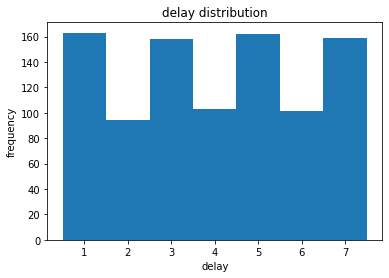

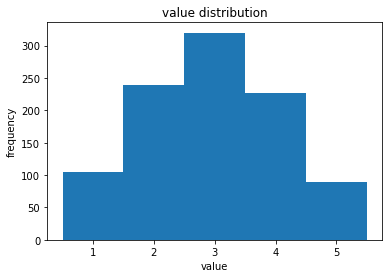

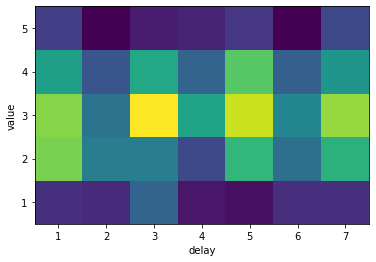

In [3]:
samples = 1000

delays = [get_delay() for i in range(samples)]
delay_bins = np.array([0,1,2,3,4,5,6,7]) + 0.5

values = [get_value() for i in range(samples)]
value_bins = np.array([0,1,2,3,4,5]) + 0.5


plt.hist(delays, bins=delay_bins)
plt.title("delay distribution")
plt.xlabel("delay")
plt.ylabel("frequency")
plt.show()

plt.hist(values, bins=value_bins)
plt.title("value distribution")
plt.xlabel("value")
plt.ylabel("frequency")
plt.show()

plt.hist2d(delays, values, bins=[delay_bins, value_bins])
plt.xlabel("delay")
plt.ylabel("value")
plt.show()

In [4]:
def create_value_df(events):
    data = [(get_delay(), get_value(), get_name()) for i in range(events)]
    df = pd.DataFrame(data=data, columns=["delay", "value", "name"])
    df.index.name = "eventID"
    return df
    
    

In [5]:
events = 10000

df= create_value_df(events)
df.head()

,delay,value,name
eventID,,,
0,0.935197,2.635659,bad ion
1,5.307893,2.489501,bad ion
2,7.534654,2.581745,bad ion
3,4.256861,3.153592,bad ion
4,0.916689,2.697898,bad ion


In [6]:
df[df.name == "good ion"][:3]  # sort by name

,delay,value,name
eventID,,,
5,6.937035,2.299740,good ion
7,4.215516,5.117318,good ion
8,3.480487,1.065285,good ion


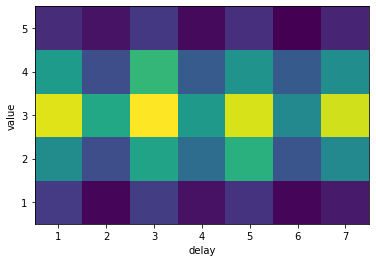

In [7]:
plt.hist2d(df[df.name == "good ion"]["delay"],
           df[df.name == "good ion"]["value"],
           bins=[delay_bins, value_bins])
plt.xlabel("delay")
plt.ylabel("value")
plt.show()

### normalize on events per delay bin 

,delay,value,name,delay_bin,weight
eventID,,,,,
0,0.935197,2.635659,bad ion,1.0,0.000633
1,5.307893,2.489501,bad ion,5.0,0.000623
2,7.534654,2.581745,bad ion,NaN,NaN
3,4.256861,3.153592,bad ion,4.0,0.001054
4,0.916689,2.697898,bad ion,1.0,0.000633


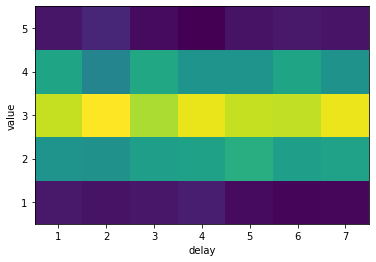

In [8]:
delay_labels = [(a+b)/2 for a,b in zip(delay_bins[:-1],delay_bins[1:])]

df["delay_bin"] = pd.cut(df["delay"], bins=delay_bins, labels=delay_labels)
events_per_delay_bin = df.groupby(df["delay_bin"]).size()   
df["weight"] =  df['delay_bin'].apply(lambda x: 1./events_per_delay_bin[x])


plt.hist2d(df["delay"], df["value"], bins=[delay_bins, value_bins], weights=df["weight"])
plt.xlabel("delay")
plt.ylabel("value")

df.head()

## traces

In [9]:
def get_trace(delay=0):
    return 10 * np.sin(np.arange(0, 100, 1)/10+delay/3) + _add_noise_to_trace()

def _add_noise_to_trace(mean=0., width=3):
    return np.random.normal(mean, width, 100)

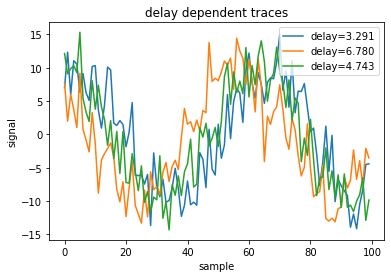

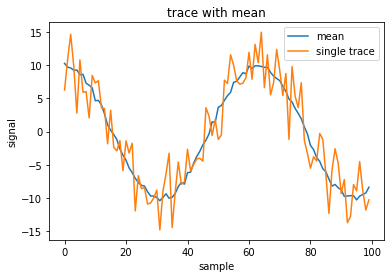

In [10]:
delays = [get_delay() for i in range(3)]

for delay in delays:
    plt.plot(get_trace(delay), label=f"{delay=:.3f}")
plt.title("delay dependent traces")
plt.xlabel("sample")
plt.ylabel("signal")
plt.legend()
plt.show()

mean_trace = np.mean([get_trace(delay) for i in range(100)], axis=0)

plt.plot(mean_trace, label="mean")
plt.plot(get_trace(delay), label="single trace")
plt.title("trace with mean")
plt.xlabel("sample")
plt.ylabel("signal")
plt.legend()
plt.show()

In [11]:
def create_traces_df(events):
    delays = [get_delay() for i in range(events)]
    traces = [get_trace(delay) for delay in delays]
    df = pd.DataFrame({"delay": delays,
                       "trace": traces})
    df.index.name = "trainID"
    return df                                          
                                    

In [12]:
events = 10000

df= create_traces_df(events)
df.head()

,delay,trace
trainID,,
0,7.417397,"[0.12969967211984734, 6.230393977766246, 5.886..."
1,1.850567,"[4.23646605707475, 12.169272011275133, 8.27877..."
2,7.293976,"[12.53410013471505, 4.800483119375432, 2.91181..."
3,0.612969,"[-0.2598748186746196, -1.8655412239527926, 9.4..."
4,1.926292,"[3.360475779675699, 6.524516078838554, 10.0508..."


### bin into delay steps

In [13]:
delay_bins = np.array([0,1,2,3,4,5,6,7]) + 0.5
delay_labels = [(a+b)/2 for a,b in zip(delay_bins[:-1],delay_bins[1:])]
df["delay_bin"] = pd.cut(df["delay"], bins=delay_bins, labels=delay_labels)

print(df.groupby(df["delay_bin"]).size())

delay_bin
1.0    1528
2.0     935
3.0    1621
4.0    1044
5.0    1626
6.0    1017
7.0    1553
dtype: int64


### mean of delay steps

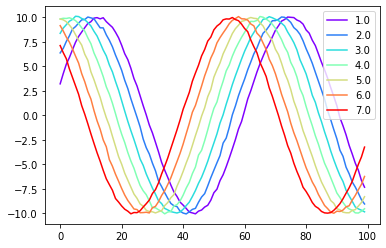

In [14]:
colors = cm.rainbow(np.linspace(0, 1, len(delay_labels)))

df_mean = pd.DataFrame(data=[df[df["delay_bin"] == delay]["trace"].mean() for delay in delay_labels],
                       index=delay_labels)

for delay, color in zip(df_mean.index, colors):
    plt.plot(df_mean.loc[delay], label=delay, color=color)
plt.legend();

### heatmap

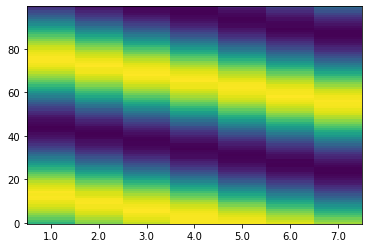

In [15]:
heatmap = np.zeros((len(df_mean.iloc[0]), len(df_mean.index)) , dtype = float)

for i in range(len(df_mean.index)):
    heatmap[:,i] = df_mean.iloc[i]
    

plt.imshow(heatmap,  aspect="auto", origin="lower", interpolation="none")
plt.gca().set_xticks(np.arange(len(delay_labels)))
plt.gca().set_xticklabels(delay_labels);

## images

In [16]:
def get_image(delay=0):
    size, fwhm = 256, 25
    x0, y0 = 35 * delay, 35 * delay 
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    image = np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)  # square gaussian kernel
    return image + _add_noise_to_image(image.shape)

def _add_noise_to_image(image_shape, mean=0., width=1):
    return np.random.normal(mean, width, image_shape)



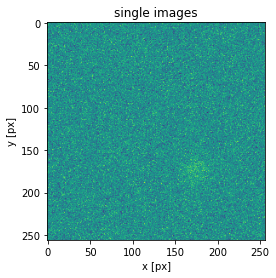

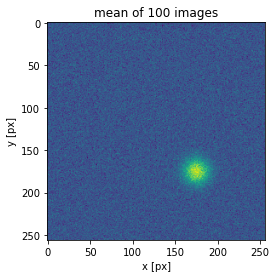

In [17]:
images = np.array([get_image(5) for i in range(100)])
mean_image = np.mean(images, axis=0)

plt.imshow(images[0])
plt.title("single images")
plt.xlabel("x [px]")
plt.ylabel("y [px]")
plt.show()

plt.imshow(mean_image)
plt.title("mean of 100 images")
plt.xlabel("x [px]")
plt.ylabel("y [px]")
plt.show()


In [18]:
def create_images_df(events):
    delays = [get_delay() for i in range(events)]
    images = [get_image(delay) for delay in delays]
    df = pd.DataFrame({"delay": delays,
                       "image": images})
    df.index.name = "trainID"
    return df                                          



In [19]:
events = 1000

df= create_images_df(events)
df.head()

,delay,image
trainID,,
0,2.065582,"[[0.82674458068563, -0.8146000278226986, 0.335..."
1,5.267136,"[[0.37970383280654374, -0.9745857413833829, -0..."
2,2.387079,"[[0.5892363557130964, 1.4877505490695009, 0.53..."
3,5.042360,"[[-1.8019761992173382, 0.30064479489631185, -1..."
4,4.758040,"[[-0.996515906527262, 0.22866180557292942, 1.0..."


### bin into delay steps

In [20]:
delay_bins = np.array([0,1,2,3,4,5,6,7]) + 0.5
delay_labels = [(a+b)/2 for a,b in zip(delay_bins[:-1],delay_bins[1:])]
df["delay_bin"] = pd.cut(df["delay"], bins=delay_bins, labels=delay_labels)

print(df.groupby(df["delay_bin"]).size())

delay_bin
1.0    141
2.0    103
3.0    186
4.0    100
5.0    158
6.0     88
7.0    157
dtype: int64


### mean of delay steps

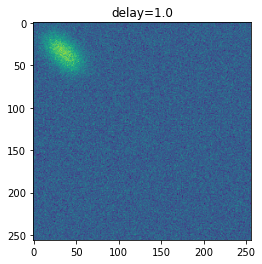

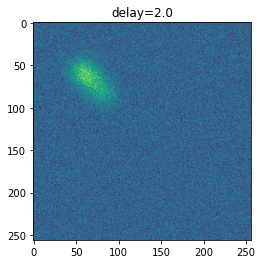

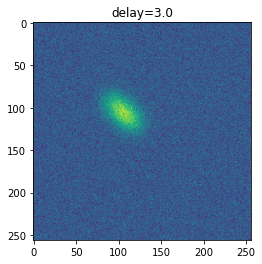

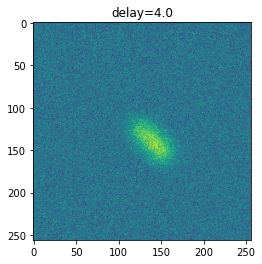

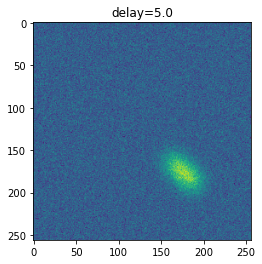

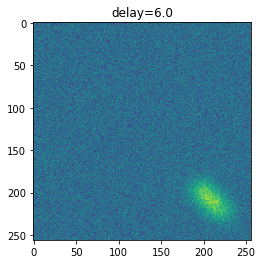

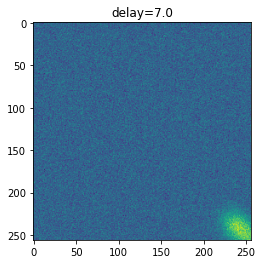

In [21]:
df_mean = pd.DataFrame(data=[[df[df["delay_bin"] == delay]["image"].mean(axis=0)] for delay in delay_labels],
                       index=delay_labels) 

for delay in df_mean.index:
    plt.imshow(df_mean.loc[delay][0])
    plt.title(f"{delay=}")
    plt.show()

